# Testing QCBM concept 1

The rationale behind this test is to split a time-series dataset of numbers from 1-10 into 10 subsections, a QCBM will be responsible for learning the distribution of each subset. By sampling each synthetic distribution, we can see if the original distribution is learnt to an acceptable degree

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from braket.circuits import Circuit, FreeParameter, Gate, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsQuantumTask
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot_2samples


device = LocalSimulator()





# function to convert data in the interval (vmin-epsilon,vmax+epsilon) into bitstring using 12-bit precision
def data_to_bitstring(value,vmin,vmax,epsilon=0,precision=12):
    int_value = int((value - vmin + epsilon)/((vmax-vmin)+2*epsilon)*(2**precision-1))
    bitstring = format(int_value,'012b')
    return bitstring

# convert bitstring of length precision to a data point in the range (vmin-epsilon,vmax+epsilon)
def bitstring_to_data(bitstring,vmin,vmax,epsilon=0):
    precision = len(bitstring)
    bitstring = bitstring[::-1]
    vint = 0
    for j in range(precision):
        vint += int(bitstring[j])*(2**j)  # obtain integer representation from the bitstring
    value = vmin - epsilon + vint/(2**precision-1)*(vmax - vmin + 2*epsilon) # bring into the range (vmin-epsilon,vmax+epsilon)
    return value





def circuit():
    # Construct the PQC (parameterized quantum circuit) ansatz for the Quantum Circuit Born Machine (QCBM)
    qcbm = Circuit()
    wires = 8 # number of wires corresponding to the bit precision required for the data, here 12 bits
    depth = 7  # number of parametrised 1-qubit gate layers
    theta = [[FreeParameter("t_%s_%s" % (l,q)) for q in range(wires)] for l in range(depth)]
    # free parameters (angles) are labelled t_i_j, where i is the layer of the circuit and j the wire

    for q in range(wires):
        qcbm.rx(q,theta[0][q])  # layer of rx gates with unspecified parameters
        qcbm.rz(q,theta[1][q])  # layer of rz gates with unspecified parameters

    for q in range(wires//2):       ## layer of interlinked cnot gates for entanglement
        qcbm.cnot(control=2*q,target=(2*q+1)%wires)
    for q in range(wires//2):
        qcbm.cnot(control=2*q+1,target=(2*(q+1))%wires)

    for q in range(wires):
        qcbm.rz(q,theta[2][q]) # layer of rx gates with unspecified parameters
        qcbm.rx(q,theta[3][q]) # layer of rz gates with unspecified parameters
        qcbm.rz(q,theta[4][q]) # layer of rx gates with unspecified parameters

    for q in range(wires//2):       ## layer of interlinked cnot gates for entanglement
        qcbm.cnot(control=wires-1-2*q,target=(wires-2*q)%wires)
    for q in range(wires//2):
        qcbm.cnot(control=wires-2-2*q,target=wires-1-2*q)

    for q in range(wires):
        qcbm.rz(q,theta[5][q])  # layer of rz gates with unspecified parameters
        qcbm.rx(q,theta[6][q])  # layer of rx gates with unspecified parameters

    return qcbm



# generate random angles in the range (-pi,pi) to initialize the parameters of the QCBM
def random_thetas(m=7,dim=[8,7]):
# generate a random array of dimension 'size' each parameter can take m discrete values between -pi and +pi
    thetas = np.random.randint(2**m,size=dim)
    thetas = np.pi/2**(m-1) * thetas
    thetas -= np.pi
    return thetas

# Prepare dictionary from parameter values theta that can serve as input for the parameterized quantum circuit of the QCBM
def thetas_to_dict(thetas):
    wires, depth = thetas.shape
    theta_dict = {}
    for i in range(depth):
        for j in range(wires):
            t_str = 't_' + str(i) + '_' + str(j)
            theta_dict[t_str] = thetas[j][i]
    return theta_dict

def draw_data_sample(data,K=100):  # draws K samples randomly from the original data
    u = []                         # need these in the cost function to compare with the QCBM generated data below
    rows = len(data)
    for i in range(K):
        index = np.random.randint(rows)  # pick a random row index of the date array
        u.append(data[index])            # retrieve the data value at this index and append to u
    return u

def run_qcbm(Nthetas,vmin,vmax,epsilon=0,K=100): # samples K times from the QCBM for each set of parameters in Nthetas
    print("running qcbm...")
    Nv = []                                      # array to hold N sets of samples from K shots each
    for thetas in Nthetas:
        thetas_dict = thetas_to_dict(thetas)
        task = device.run(qcbm,shots=K,inputs=thetas_dict)   # Here the quantum circuit is executed, incurring cost
        result = task.result()                               # get results of the measurements
        counts = result.measurement_counts                   # obtain bitstrings with their respective counts
        v = []
        for bitstring, count in counts.items():
            value = bitstring_to_data(bitstring,vmin,vmax,epsilon=epsilon)  # convert bitstring to real valued data
            for i in range(count):
                v.append(value)                                             # append each data as many times as it was measured
        Nv.append(v)
    return Nv

# cost function, defined as the sum of squared differences of K generated samples and samples drawn from the original data
def cost(u,v):
    K = len(u)
    u_sorted = np.sort(u)    # sort data by value
    v_sorted = np.sort(v)    # sort generated samples by value
    squared_diff_sum = 0     # compute the sum of squared differences between the sorted samples
    for i in range(K):
        squared_diff_sum += (u_sorted[i]-v_sorted[i])**2  # add the squared difference for each data / sample pair
    return squared_diff_sum  # return the sum of squared differences




def mutation(Mthetas,D,alpha,m=7):
    Nthetas_new = []
    for thetas in Mthetas:
        wires, depth = thetas.shape
        for d in range(D):            # for each set of theta values create D mutations, generating N = M*D mutations in total
            theta_trans = thetas.copy().transpose()  # make a copy of the current theta values which is to be mutated
            for i in range(depth):
                if np.random.rand() < alpha:                                 # with probability alpha perform a mutation
                    wire = np.random.randint(wires)                          # select a random wire
                    angle = np.random.randint(2**m)*np.pi/(2**(m-1)) - np.pi # generate a random angle in (-pi,pi) in 2**m steps
                    theta_trans[i][wire] = angle                             # replace angle in the chosen wire
                    if np.random.rand() < alpha/2:                         # perform a second mutation with probability alpha/2
                        wire = np.random.randint(wires)                          # select a random wire (could be same as above)
                        angle = np.random.randint(2**m)*np.pi/(2**(m-1)) - np.pi # generate a random angle in (-pi,pi)
                        theta_trans[i][wire] = angle                         # replace angle in the chosen wire
            Nthetas_new.append(theta_trans.transpose())                      # append mutated theta values to parameter list
    return Nthetas_new



# calculates the cost for all sets of theta values in Nthetas for the data by sampling the QCBM,
# returning the thetas sorted by cost
def thetas_by_cost(Nthetas,data,vmin,vmax,epsilon=0,K=100):
    u = draw_data_sample(data,K)                           # draw samples from the original data to compare with generated data
    Nv = run_qcbm(Nthetas,vmin,vmax,epsilon=epsilon,K=K)   # for each set of theta values, sample the QCBM K times
    cost_vector = []
    for v in Nv:                           # compute the cost function between the original data and each set of QCBM samples
        cost_vector.append(cost(u,v))
    cost_thetas = list(zip(cost_vector,Nthetas))
    cost_thetas.sort()                     # sort the list by the value of the cost function
    cost_sorted = [x for x,y in cost_thetas]
    Nthetas_sorted = [y for x,y in cost_thetas]
    return cost_sorted, Nthetas_sorted



def training(iteration):
    
    L = 2  # number of iterations (generations) for the genetic algorithm
    M = 5  # number of best solutions in the given generation, chosen for further mutation
    D = 20  # number of 'offspring' each solution (1..M) produces through mutation
    N = D*M # number of solutions in each generation
    alpha, beta = 1.0, 0.013863 # mutation parameters
    kappa = 50 # number of generations after which mutation rate has decreased by a factor of 1/2
    epsilon = 0.01   # amount by which generated data can lie outside the range of original data: (vmin - epsilon,vmax + epsilon)

    # initialize N sets of theta values with random angles
    Nthetas = []
    for i in range(N):
        Nthetas.append(random_thetas())

    # compute the cost for samples obtained from the QCBM and record the minimum
    cost_sorted, Nthetas_sorted = thetas_by_cost(Nthetas,data,dmin,dmax,epsilon=epsilon)
    print('Generation 0, cost = %.5f' % cost_sorted[0])
    cost_min = [cost_sorted[0]]

    # now run the genetic algorithm over L generations
    for gen in range(L):
        alpha *= np.exp(-beta)                # mutation probability alpha decreased exponentially (factor 1/2 for 50 generations)
        Mthetas = Nthetas_sorted[:M]          # keep only the best M sets of theta values
        Nthetas_new = mutation(Mthetas,D,alpha)
        cost_new, thetas_new = thetas_by_cost(Nthetas_new,data,dmin,dmax,epsilon=epsilon)
        message = 'Generation %i, cost = %.5f' % (gen+1, cost_new[0])
        if cost_new[0] < cost_min[-1]:        # if minimum cost of new parameters is less than previous minimum, keep them
            cost_min.append(cost_new[0])
            Nthetas_sorted = thetas_new
            print(message + '  improved!')    # print that parameters have improved
        else:
            print(message)

    thetas_opt = Nthetas_sorted[0]  # record the best values of theta parameters obtained from the genetic algorithm
    np.savetxt(f"Numbers/NumbersThetas/thetas_opt{iteration}.csv",thetas_opt,delimiter=",")  # save good parameters to a csv file (only execute to override previous)


def sample(iteration,data):
    thetas_opt = np.genfromtxt(f"Numbers/NumbersThetas/thetas_opt{iteration}.csv",delimiter=",") # load good theta parameters previously obtained to avoid
                                                            # having to run the training algorithm again
    device = LocalSimulator()    # use simulator, below we will use actual quantum hardware
    samples = np.array(run_qcbm([thetas_opt],dmin,dmax,epsilon=0.01 ,K=len(data))[0])

    print(f"Samples {iteration}: {samples}")
    samples = [round(sample,6) for sample in samples]
    #save samples to csv

    return samples

In [2]:
qcbm = circuit()
for i in range(7):
    path = f"Numbers/NumbersDataset/numbersdataset{i}.csv"
    print("Input paths: ",path)


Input paths:  Numbers/NumbersDataset/numbersdataset0.csv
Input paths:  Numbers/NumbersDataset/numbersdataset1.csv
Input paths:  Numbers/NumbersDataset/numbersdataset2.csv
Input paths:  Numbers/NumbersDataset/numbersdataset3.csv
Input paths:  Numbers/NumbersDataset/numbersdataset4.csv
Input paths:  Numbers/NumbersDataset/numbersdataset5.csv
Input paths:  Numbers/NumbersDataset/numbersdataset6.csv


In [3]:
for i in range(10):
    path = f"Numbers/NumbersDataset/numbersdataset{i}.csv"
    print(f"Starting path: {path}")
    D = pd.read_csv(path) 
    feature = "value"
    dmin = D[feature].min() # maximum value of the data
    dmax = D[feature].max() # minimum value of the data
    drange = dmax - dmin   # data range
    data = D[feature].to_numpy()  # convert data to numpy array
    training(i)
    samples = sample(i,data)
    print(samples[:10])
    #print("Samples: ",samples)
    np.savetxt(f"Numbers/NumbersSamples/samples{i}.txt",samples, delimiter=',')

Starting path: Numbers/NumbersDataset/numbersdataset0.csv
running qcbm...
Generation 0, cost = 25.55908
running qcbm...
Generation 1, cost = 20.06216  improved!
running qcbm...
Generation 2, cost = 16.38664  improved!
running qcbm...
Samples 0: [ 0.27517647  0.27517647  0.27517647  0.68709804  0.08505882  0.08505882
  0.08505882  0.08505882  0.08505882  0.08505882  0.08505882  0.08505882
  0.08505882  0.17219608  0.17219608  0.17219608  0.17219608  0.17219608
  0.17219608  0.17219608  0.17219608  0.17219608  0.98019608  0.14843137
  0.14843137  0.14843137  0.14843137  0.14843137  0.14843137  0.14843137
  0.10882353  0.10882353  0.10882353  0.10882353  0.10882353  0.10882353
  0.10882353  0.10882353  0.10882353  0.10882353  0.10882353  0.36231373
  0.36231373  0.36231373  0.36231373  0.36231373  0.36231373  0.46529412
  0.46529412  0.46529412  0.46529412  1.17823529  0.37023529  0.37023529
  0.23556863  0.23556863  0.23556863  0.23556863  0.23556863  0.23556863
  0.23556863  0.23556863 

KeyboardInterrupt: 

[[0, 0.08163265306122448], [1, 1.1428571428571428], [2, 2.0], [3, 3.0], [4, 1.0], [5, 5.0], [6, 1.2497448979591836], [7, 12.0], [8, 7.903061224489796], [9, 7.923469387755102]]
[[0, 0.482511443877551], [1, 1.4688380204081632], [2, 1.9989303877551021], [3, 3.001510520408164], [4, 1.0017758622448978], [5, 4.999797505102041], [6, 1.246419494897959], [7, 11.999491010204082], [8, 7.365153224489796], [9, 7.89046099489796]]


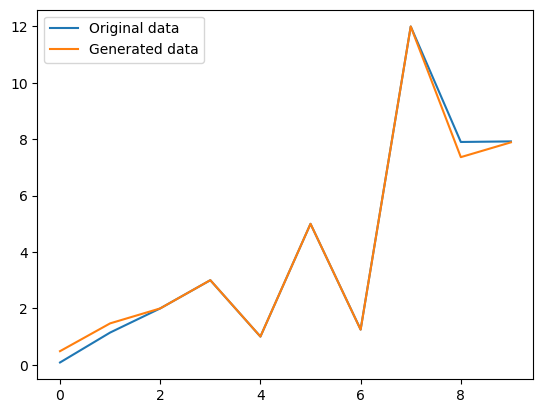

In [4]:
original_data = []
sample_data = []

for i in range(10):
    path = f"Numbers/NumbersDataset/numbersdataset{i}.csv"
    D = pd.read_csv(path) 
    feature = "value"
    data = D[feature].to_numpy()  # convert data to numpy array
    samples = np.genfromtxt(f"Numbers/NumbersSamples/samples{i}.txt", delimiter=",")
    original_data.append([i, np.mean(data)])
    sample_data.append([i, np.mean(samples)])

original_x, original_y = zip(*original_data)
sample_x, sample_y = zip(*sample_data)

print(original_data)
print(sample_data)

plt.plot(original_x, original_y, label='Original data')
plt.plot(sample_x, sample_y, label='Generated data')
plt.legend()
plt.show()